# **Simulation MACURA**

----

In [ ]:
import sys
sys.path.append('/home/lbonanni/Model-Based-Reinforcement-Learning-for-energy-management-in-smart-buildings-main/src')

from citylearn.citylearn import CityLearnEnv
from citylearn.reward_function import *
from citylearn.wrappers import *

# Data structure import
import pandas as pd
from datetime import datetime

# Plot import
from IPython.display import display, Markdown
from utils import plotting_functions as plt

# import for using model-based agents
# initialize Hydra in programmatic mode
from hydra import initialize, compose
import numpy as np
import omegaconf
import torch

# Work directory setter
import os
os.chdir('./src/agents/model_based')

import agents.model_based.mbrl.algorithms.macura as macura
import agents.model_based.mbrl.util.env as env_util

<module 'agents.model_based.mbrl.algorithms.macura' from '/content/drive/MyDrive/Colab Notebooks/src/agents/model_based/mbrl/algorithms/macura.py'>

In [ ]:
def run(cfg: omegaconf.DictConfig, test_cfg: omegaconf.DictConfig = None):
    print(f"Using the following algorithm: {cfg.algorithm.name}!")
    env, term_fn, reward_fn = env_util.EnvHandler.make_env(cfg, test_env=False)
    distance_env, *_ = env_util.EnvHandler.make_env(cfg, test_env=True)
    print(f"Using the following reward function: {reward_fn.__class__.__name__}")
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    test_env, *_ = env_util.EnvHandler.make_env(test_cfg, test_env=True)
    macura.train(env, test_env,distance_env, term_fn, cfg, work_dir="./exp/macura")
    return env,test_env,distance_env

# Clean Hydra
from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()
# Load cfg
initialize(config_path="./mbrl/examples/conf")
cfg = compose(config_name="main_macura")
test_cfg = compose(config_name="test_macura")
# Clean previous result
[shutil.rmtree(p) if os.path.isdir(p) else os.unlink(p) for p in [os.path.join('./exp/macura', f) for f in os.listdir('./exp/macura')]]
# Run agent
env, test_env, distance_env = run(cfg, test_cfg)

Output streaming troncato alle ultime 5000 righe.
| train          | S: 123000 | BR: -8.3711 | ALOSS: 13.7899 | TENTR: -9.0000 | CLOSS: 2.9449 | TLOSS: 0.0346 | ALPHA: 0.5715 | AENTR: -9.0618
| model_train    | I: 0 | E: 0 | TD: 11688 | VD: 2922 | MLOSS: -57.5257 | MVSCORE: 0.0481 | MBVSCORE: 0.0465
| model_train    | I: 0 | E: 1 | TD: 11688 | VD: 2922 | MLOSS: -57.7567 | MVSCORE: 0.0511 | MBVSCORE: 0.0464
| model_train    | I: 0 | E: 2 | TD: 11688 | VD: 2922 | MLOSS: -57.8466 | MVSCORE: 0.0528 | MBVSCORE: 0.0464
| model_train    | I: 0 | E: 3 | TD: 11688 | VD: 2922 | MLOSS: -57.8907 | MVSCORE: 0.0499 | MBVSCORE: 0.0463
| model_train    | I: 0 | E: 4 | TD: 11688 | VD: 2922 | MLOSS: -57.9168 | MVSCORE: 0.0520 | MBVSCORE: 0.0463
| model_train    | I: 0 | E: 5 | TD: 11688 | VD: 2922 | MLOSS: -57.9476 | MVSCORE: 0.0517 | MBVSCORE: 0.0463
| model_train    | I: 0 | E: 6 | TD: 11688 | VD: 2922 | MLOSS: -57.9406 | MVSCORE: 0.0533 | MBVSCORE: 0.0463
| model_train    | I: 0 | E: 7 | TD: 11688 | 


----

## **Cost Function and building parameter**

In [ ]:
env = env.unwrapped
eval_env = test_env.unwrapped
display(eval_env.time_step)

# Setting benchmark building
num_building = 0

2207

In [ ]:
kpis_names = {
    'electricity_consumption_total': 'Total grid consumption',
    'carbon_emissions_total': 'Emissions',
    'discomfort_proportion': 'Proportion of time outside comfort range',
    'daily_peak_minus_load_factor_average': 'Measure of inefficiency in daily power usage',
    'daily_peak_average': 'Average daily peak',
    'all_time_peak_average': 'Maximum district consumption peak',
    'one_minus_thermal_resilience_proportion': 'Discomfort proportion during power outages',
    'power_outage_normalized_unserved_energy_total': 'Unmet demand due to energy shortage',
    'ramping_average': 'Average difference between current and previous timestep consumption',
    # Here to add cost function
}

display(Markdown(f"### **MACURA - Base Version**"))
display(Markdown("----"))

kpis = eval_env.evaluate()
kpis = kpis[(kpis['cost_function'].isin(kpis_names))].dropna()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
display(kpis)

name                                           Building_1  Building_2  \
cost_function                                                           
all_time_peak_average                                 NaN         NaN   
carbon_emissions_total                              0.827       1.099   
daily_peak_average                                    NaN         NaN   
discomfort_proportion                               0.047       0.011   
electricity_consumption_total                       0.828       1.096   
one_minus_thermal_resilience_proportion             0.308       0.462   
power_outage_normalized_unserved_energy_total       0.533       0.733   
ramping_average                                       NaN         NaN   

name                                           Building_3  District  
cost_function                                                        
all_time_peak_average                                 NaN     0.986  
carbon_emissions_total                              0.914     0.947  
daily_peak_average                                    NaN     0.936  
discomfort_proportion                               0.010     0.023  
electricity_consumption_total                       0.913     0.946  
one_minus_thermal_resilience_proportion             0.167     0.312  
power_outage_normalized_unserved_energy_total       0.493     0.587  
ramping_average                                       NaN     0.917


------

## **Consumption Behavior**

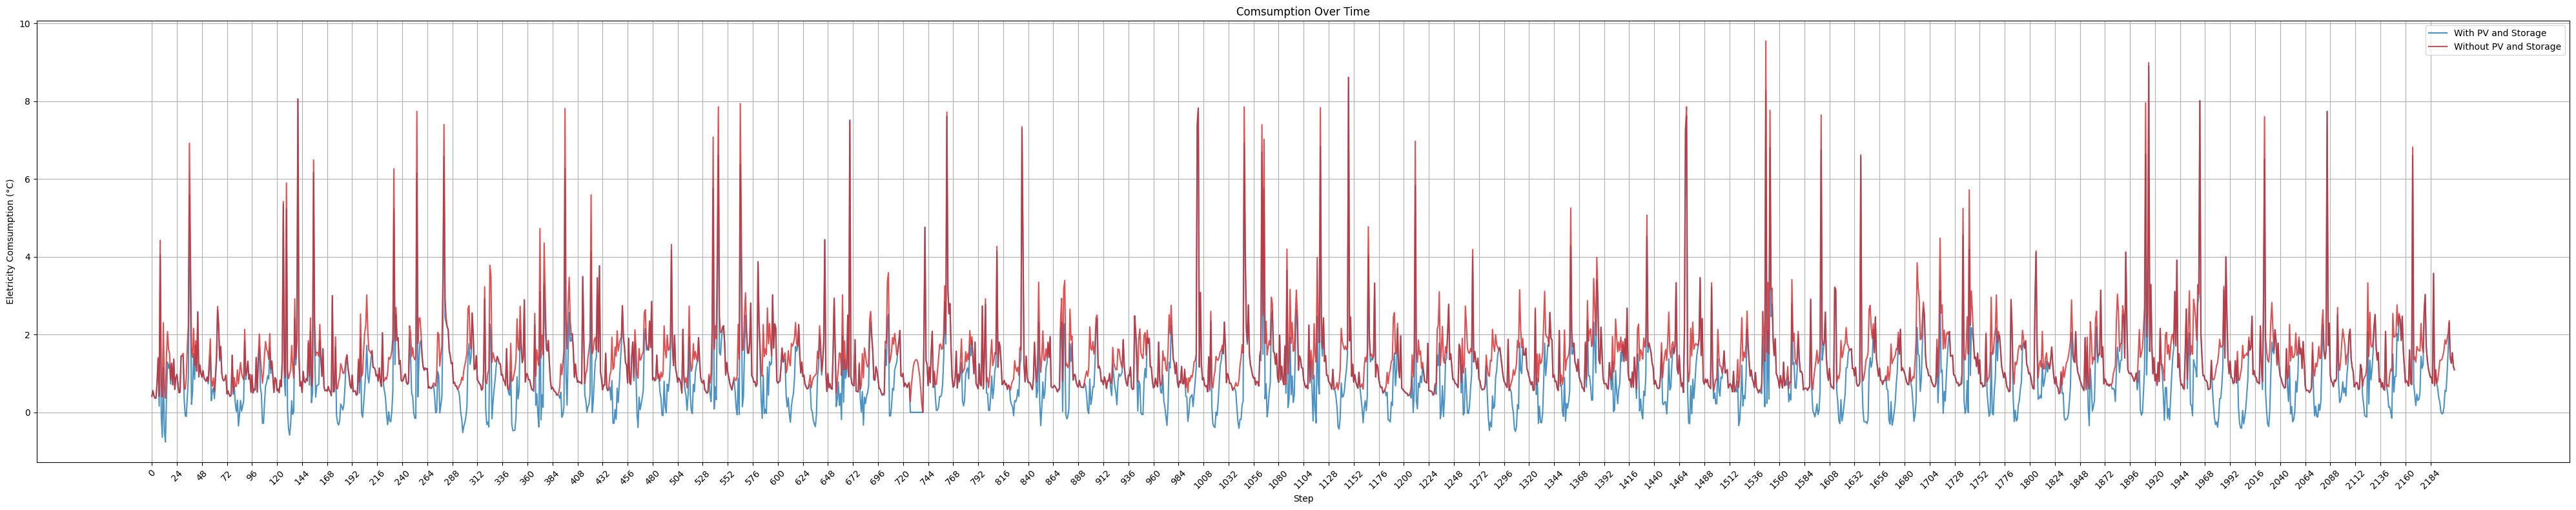

In [ ]:
energy_with_pv= eval_env.buildings[num_building].net_electricity_consumption
energy_without_pv = eval_env.buildings[num_building].net_electricity_consumption_without_storage_and_pv

plt.plot_comparison_two(
    energy_with_pv,
    energy_without_pv,
    ylabel='Eletricity Comsumption (°C)',
    title='Comsumption Over Time',
    label1='With PV and Storage',
    label2='Without PV and Storage'
)

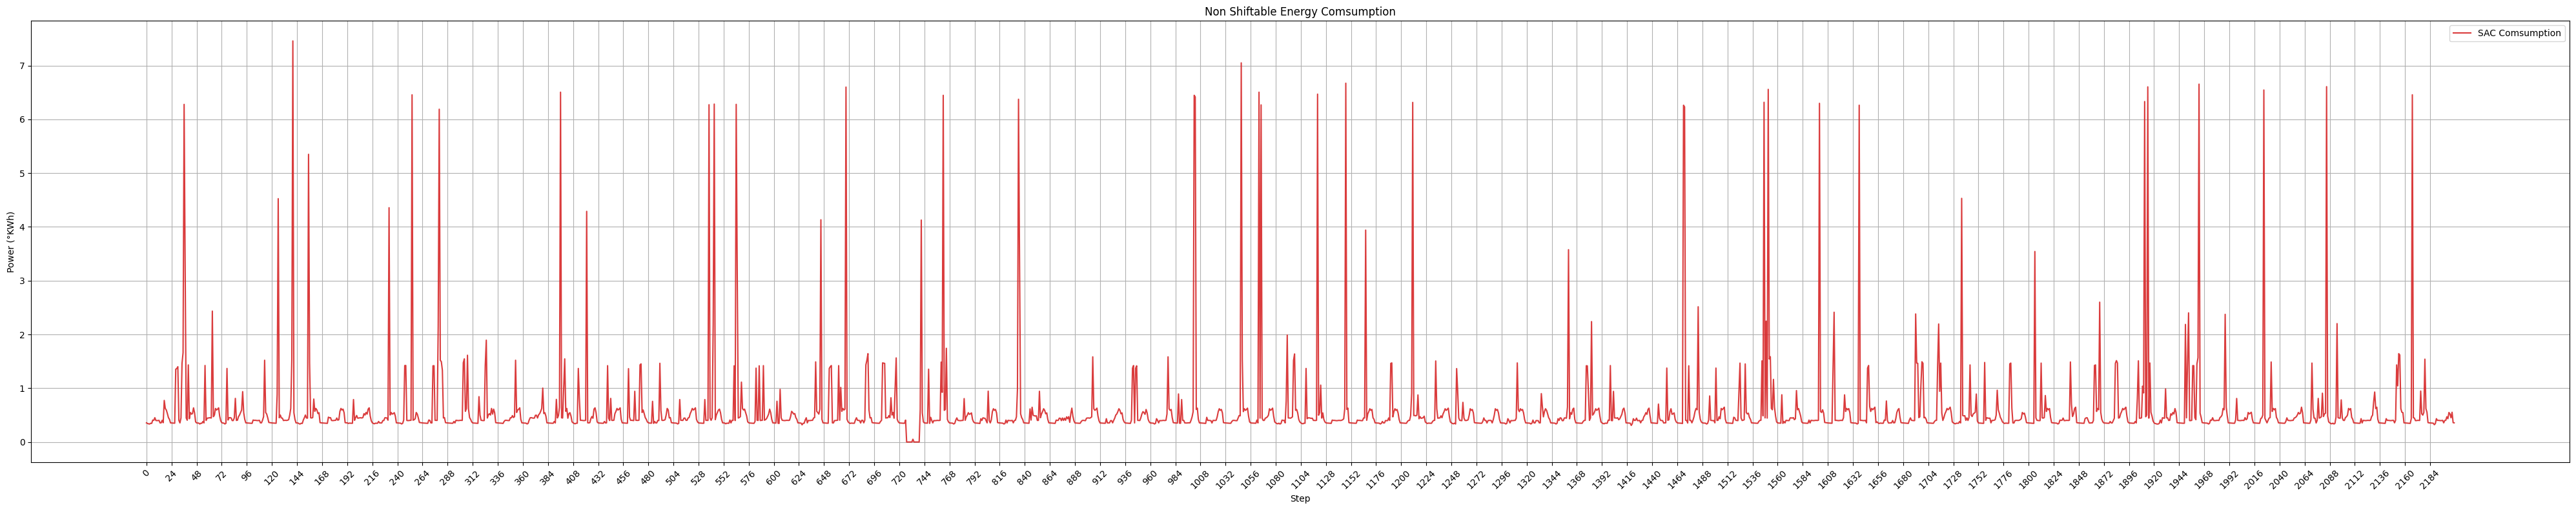

In [ ]:
non_energy = eval_env.buildings[num_building].non_shiftable_load_electricity_consumption

plt.plot_single_agent(
    non_energy,
    ylabel='Power (°KWh)',
    title='Non Shiftable Energy Comsumption',
    label='MACURA Comsumption',
)


------

## **Temperature behavior**

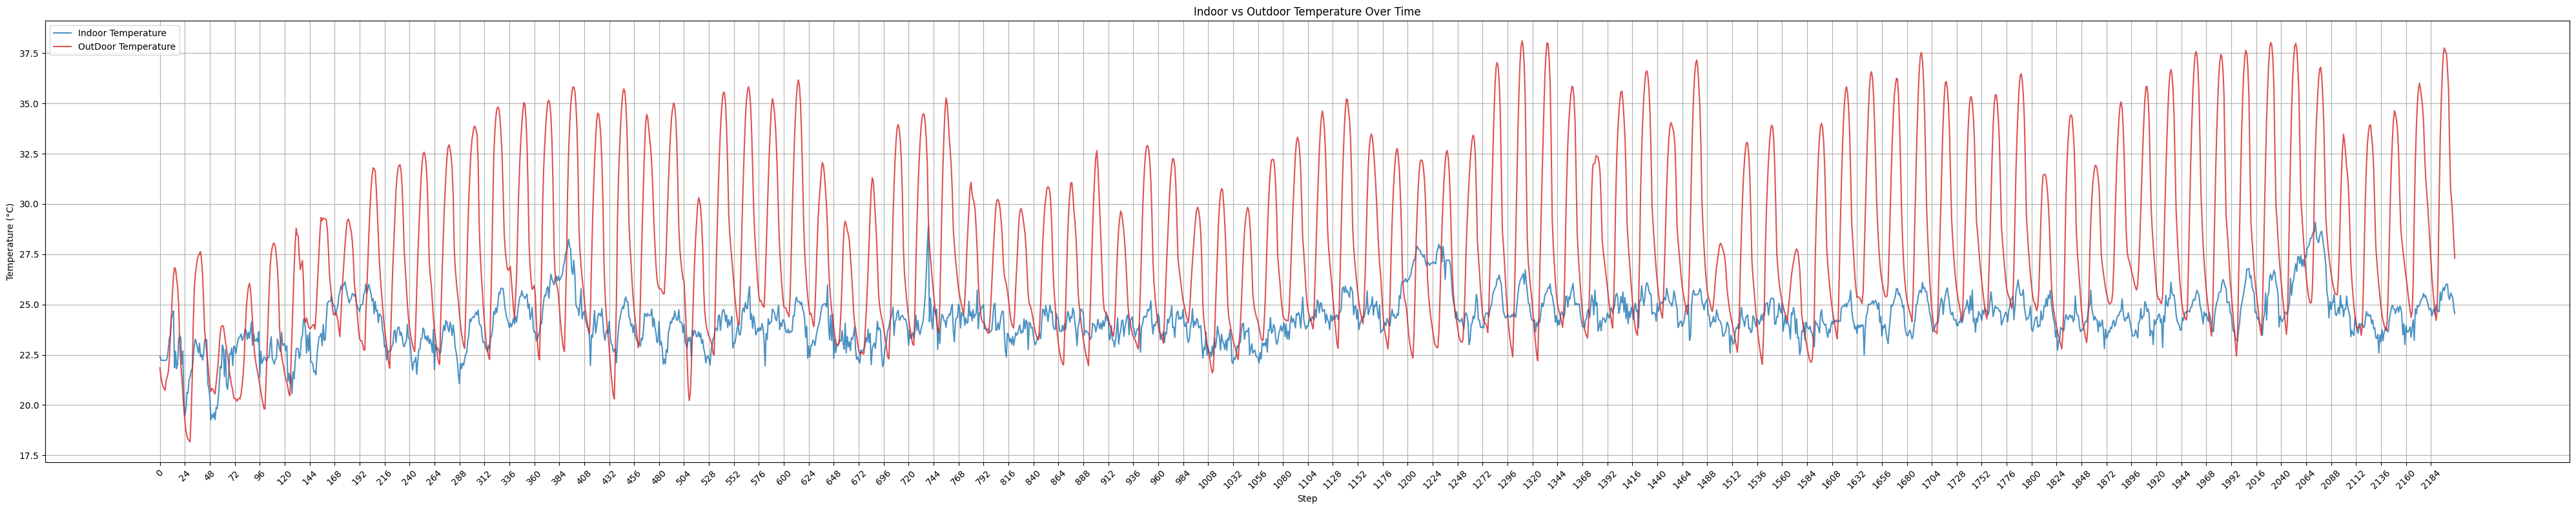

In [ ]:
indoor_base_temp = eval_env.buildings[num_building].indoor_dry_bulb_temperature
outdoor_temp = eval_env.buildings[num_building].weather.outdoor_dry_bulb_temperature

plt.plot_comparison_two(
    indoor_base_temp,
    outdoor_temp,
    ylabel='Temperature (°C)',
    title='Indoor vs Outdoor Temperature Over Time',
    label1='Indoor Temperature',
    label2='OutDoor Temperature'
)

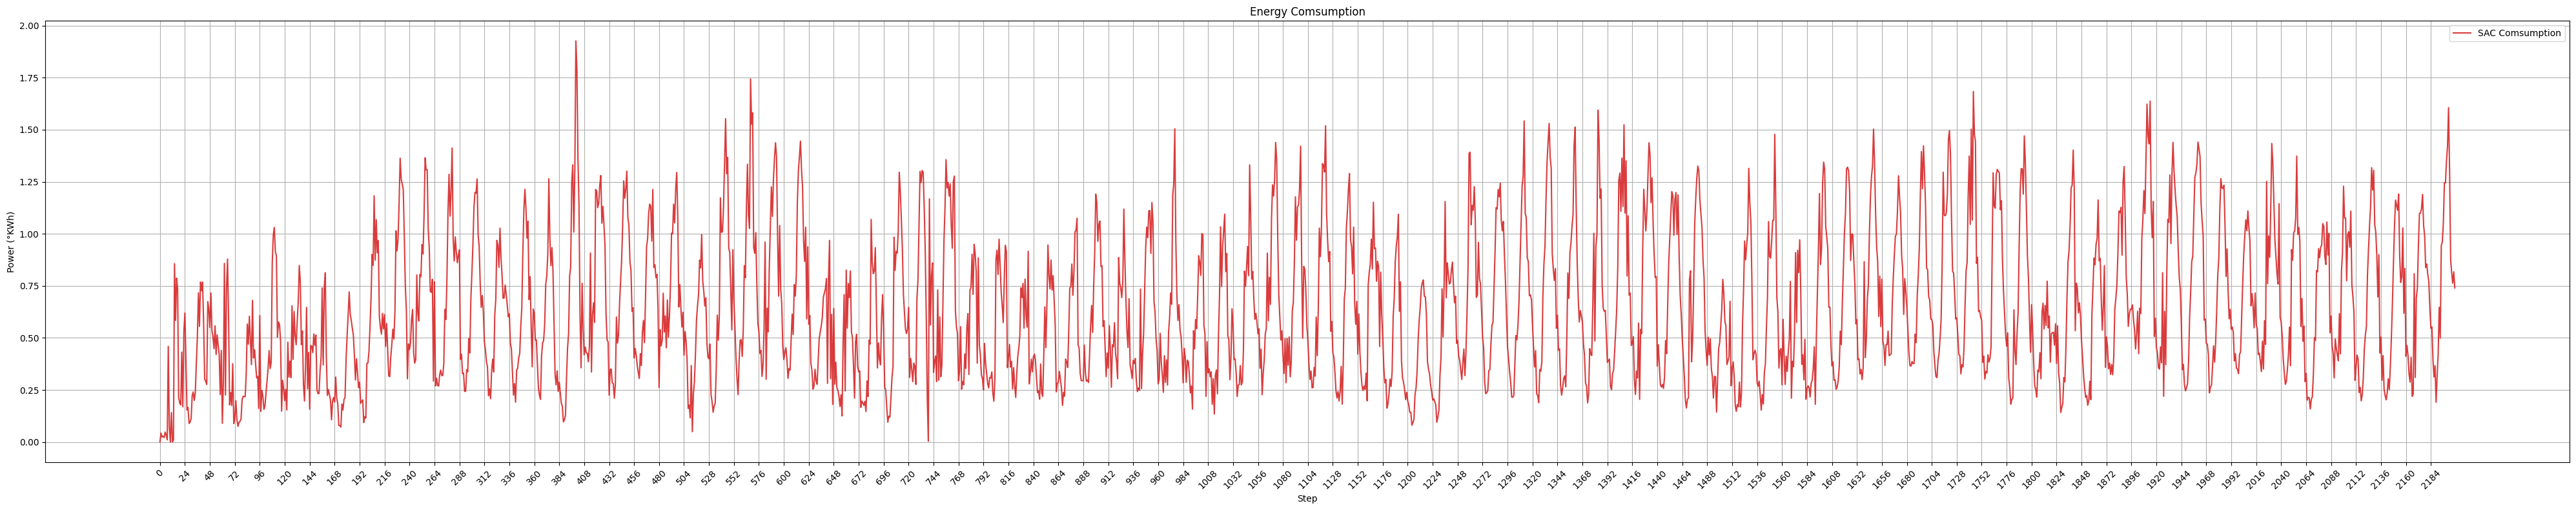

In [ ]:
cooler_energy = eval_env.buildings[num_building].cooling_electricity_consumption

plt.plot_single_agent(
    cooler_energy,
    ylabel='Power (°KWh)',
    title='Energy Comsumption',
    label='MACURA Comsumption',
)


----

## **Batteries and accumulators behavior**

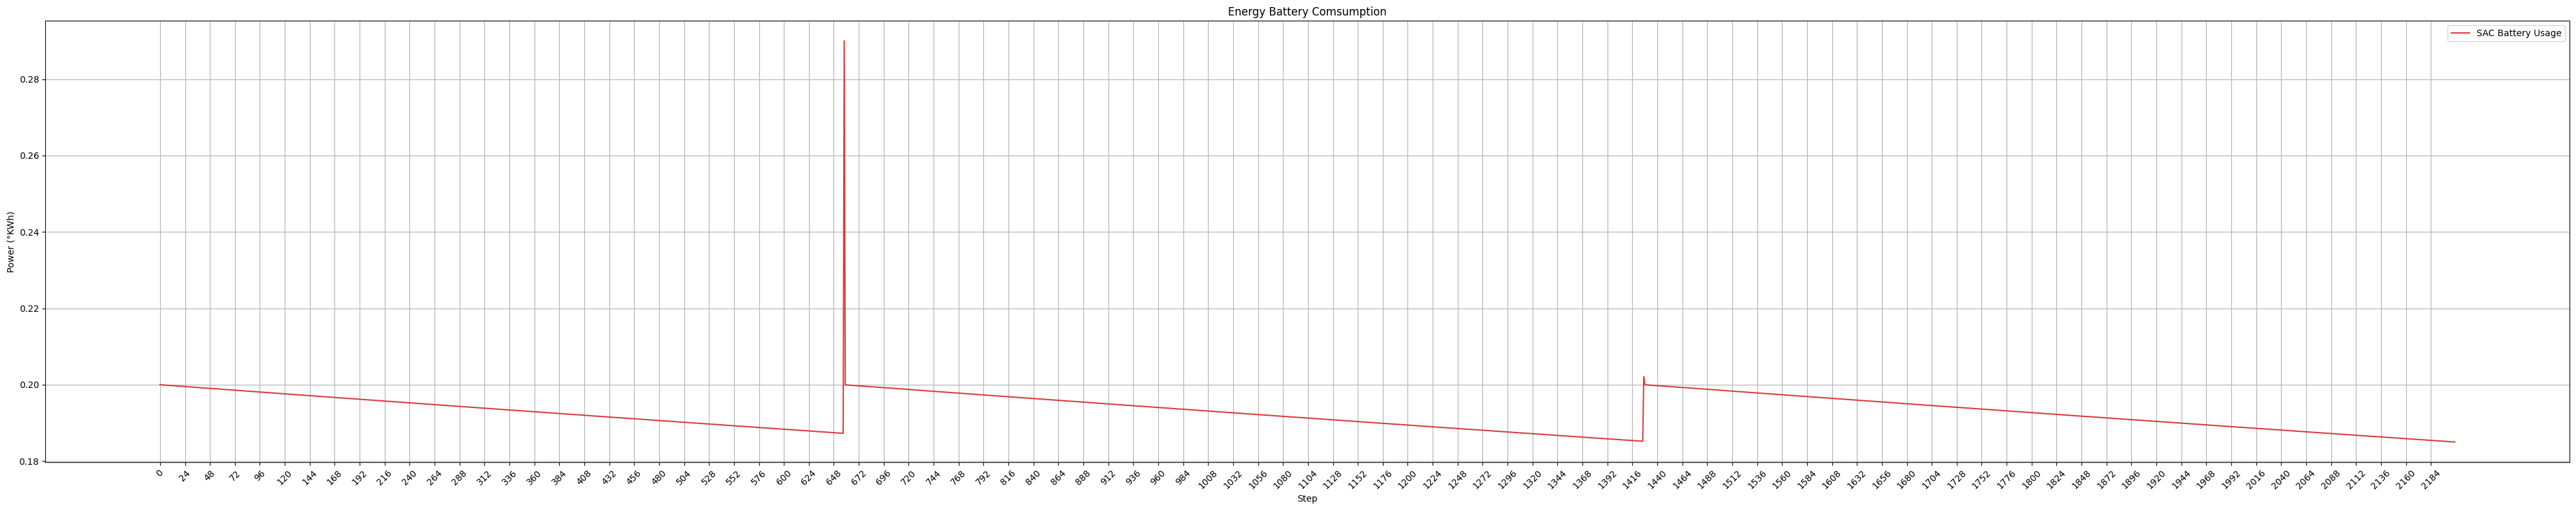

In [ ]:
agent_data1 = eval_env.buildings[num_building].electrical_storage.soc

plt.plot_single_agent(
    agent_data1,
    ylabel='Power (°KWh)',
    title='Energy Battery Comsumption',
    label='MACURA Battery Usage'
)

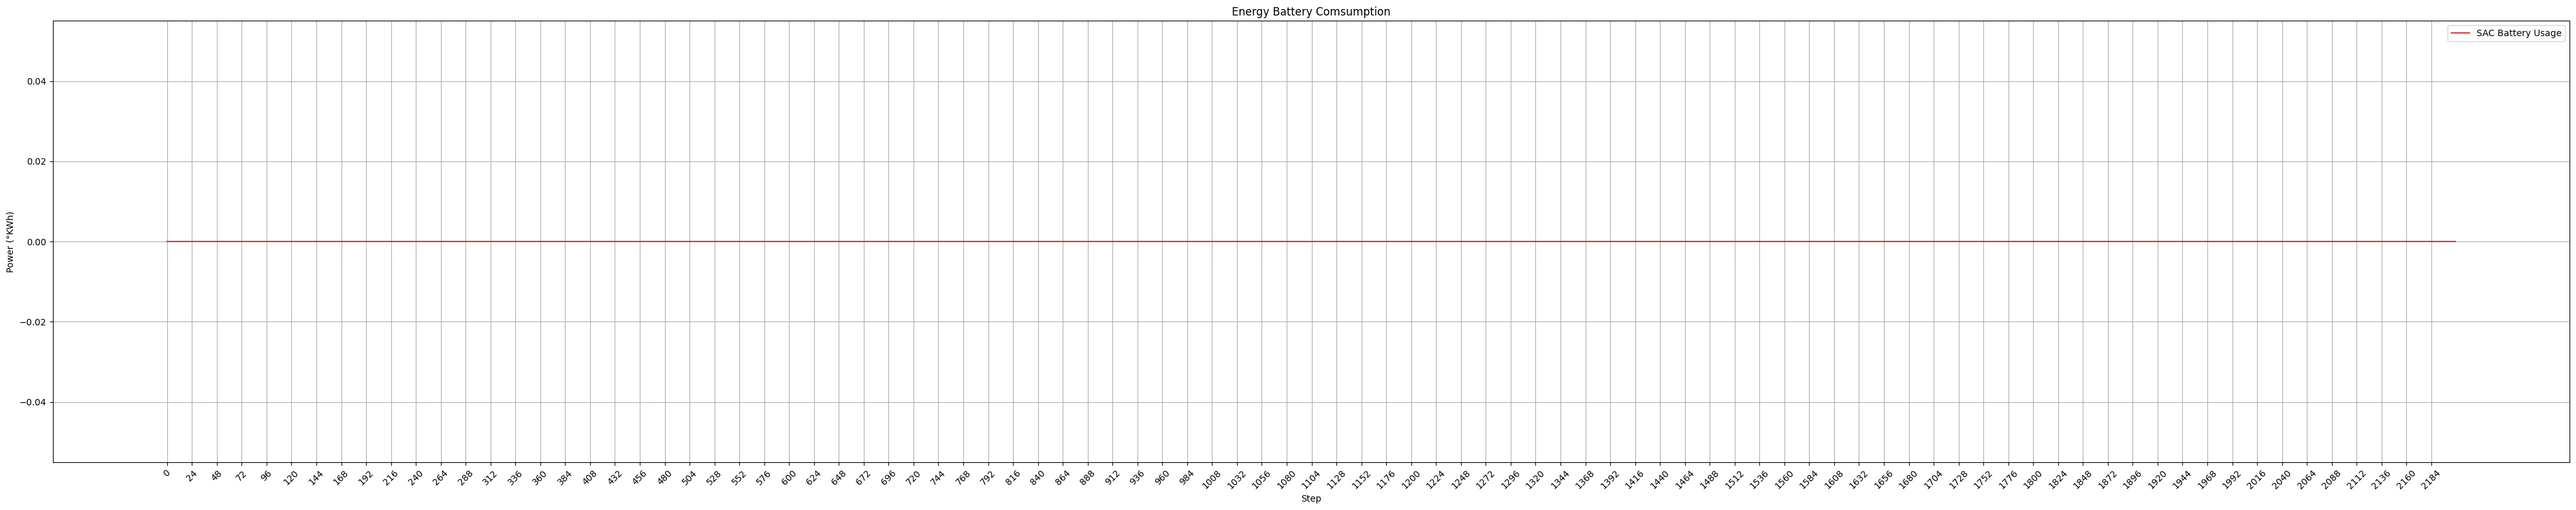

In [ ]:
agent_data1 = eval_env.buildings[num_building].dhw_storage.soc

plt.plot_single_agent(
    agent_data1,
    ylabel='Power (°KWh)',
    title='Energy Battery Comsumption',
    label='DHW Usage'
)


----

## **Emissions behavior**


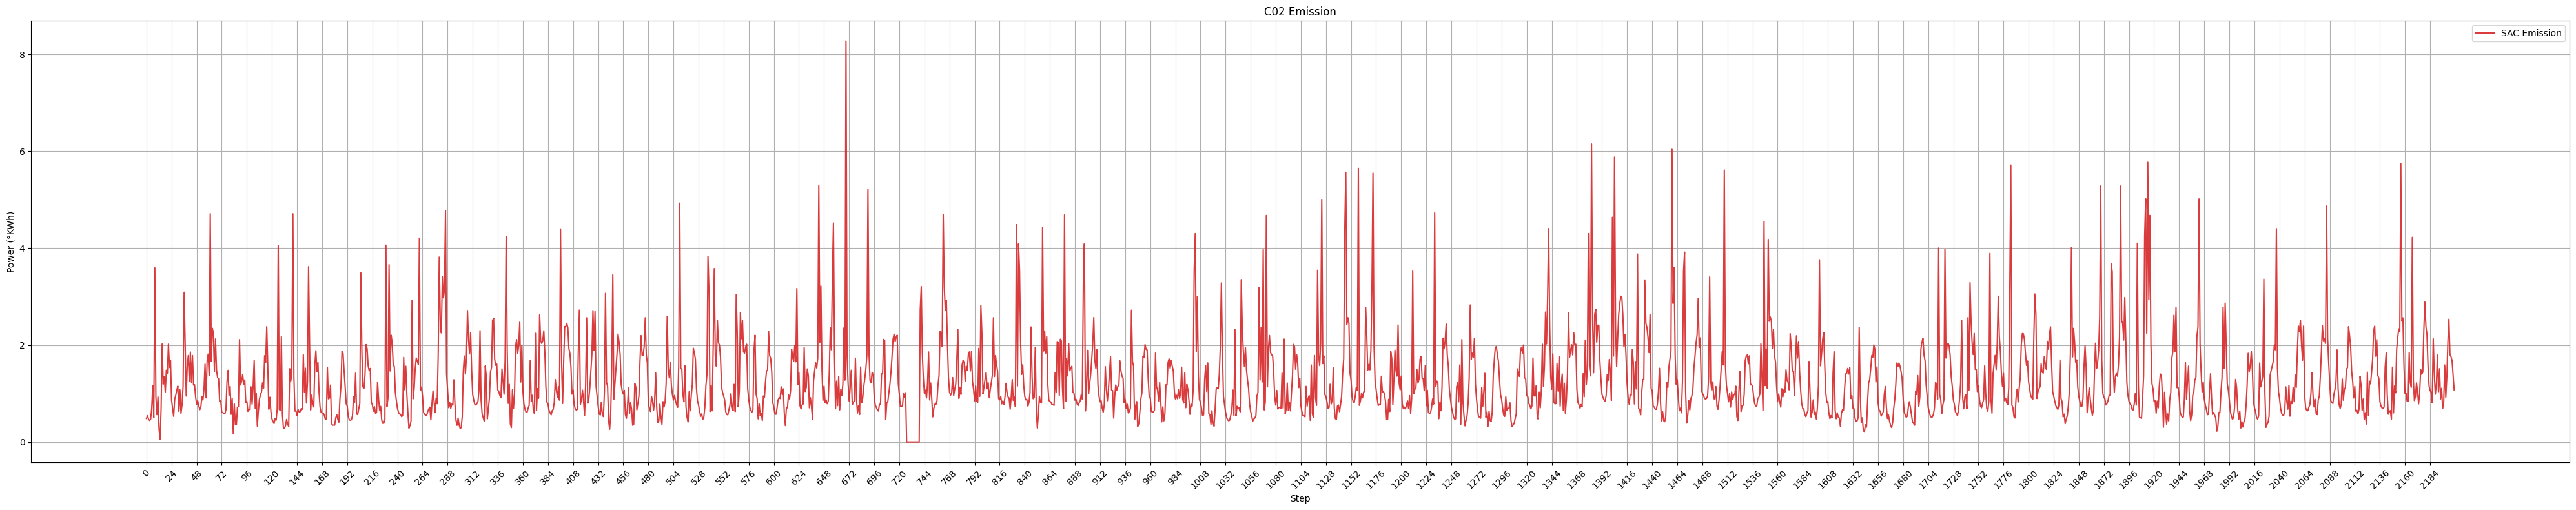

In [ ]:
agent_data1 = eval_env.net_electricity_consumption_emission

plt.plot_single_agent(
    agent_data1,
    ylabel='Power (°KWh)',
    title='C02 Emission',
    label='MACURA Emission'
)

## **Learning metrics**

Episodio  Reward Min  Reward Max  Reward Somma  Reward Media
0          1  -83.333344   -1.901769 -45380.992188    -20.562298
1          2  -90.446274   -0.854437 -28354.898438    -12.847712
2          3  -77.891998   -0.861317 -22553.640625    -10.219139
3          4  -80.959885   -1.605597 -26804.593750    -12.145262
4          5  -57.524647   -0.641665 -22031.533203     -9.982571
5          6  -61.879745   -0.969301 -22773.976562    -10.318974
6          7  -54.975075   -0.796026 -20746.666016     -9.400393
7          8  -45.667255   -0.886105 -18126.792969     -8.213318
8          9  -44.848568   -0.384062 -17897.365234     -8.109364
9         10  -51.425735   -0.542425 -20232.183594     -9.167278
10        11  -44.702328   -0.113535 -21313.691406     -9.657313
11        12  -42.897781    0.000000 -18694.150391     -8.470390
12        13  -43.252975   -0.330896 -17991.880859     -8.152189
13        14  -43.222427   -0.453650 -18150.882812     -8.224234
14        15  -45.425602   -0.206959 -17327.796875     -7.851290
15        16  -45.232109   -0.131117 -17688.716797     -8.014824
16        17  -44.102451   -0.465195 -17005.181641     -7.705112
17        18  -44.911522   -0.309809 -17320.744141     -7.848094
18        19  -46.217213   -0.035944 -16821.345703     -7.621815
19        20  -45.421677    0.000000 -17063.277344     -7.731435
20        21  -46.735180   -0.288164 -16668.878906     -7.552732
21        22  -46.838764   -0.133463 -16789.390625     -7.607336

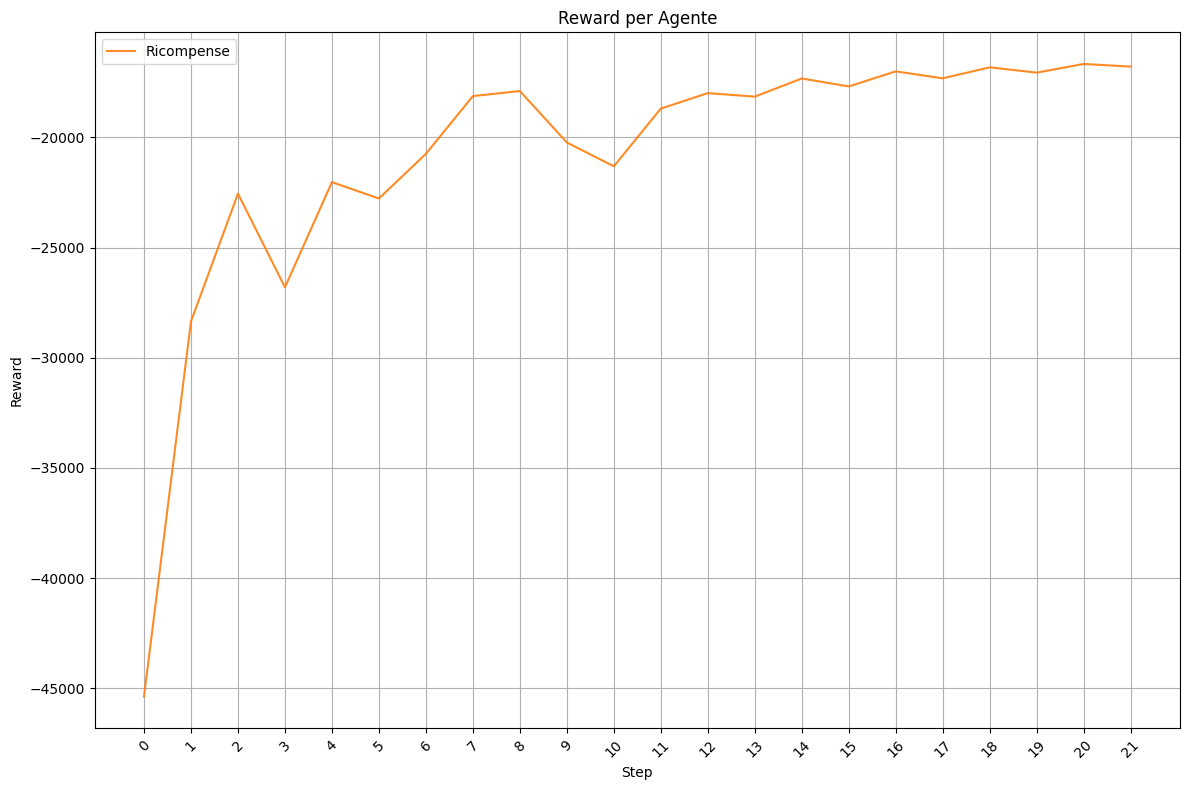

In [ ]:
df = plt.create_episode_table(eval_env.episode_rewards)

display(Markdown(f"### **MACURA - Base Version**"))
display(Markdown("----"))
display(df)

plt.plot_rewards(df['Reward Sum'])

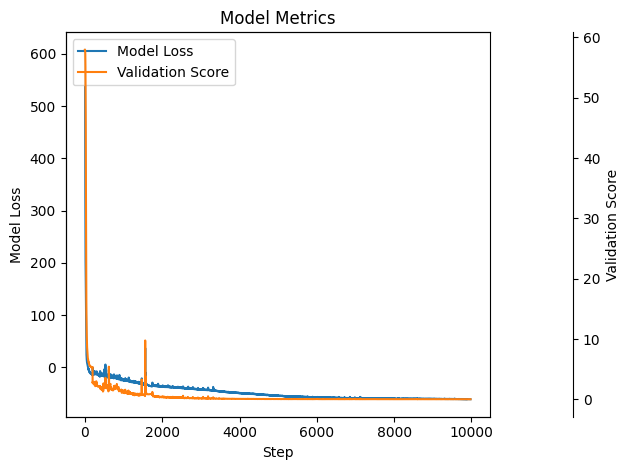

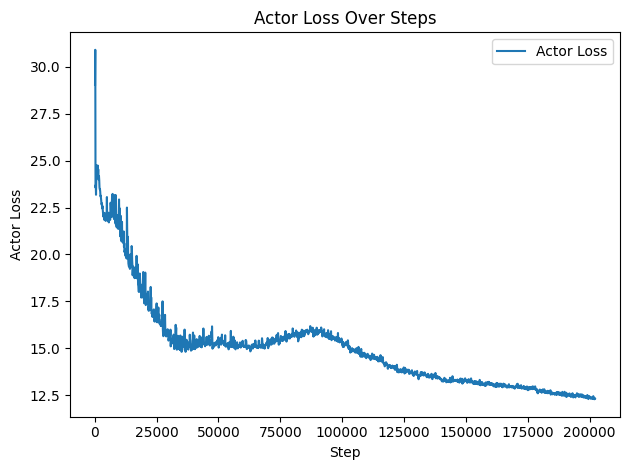

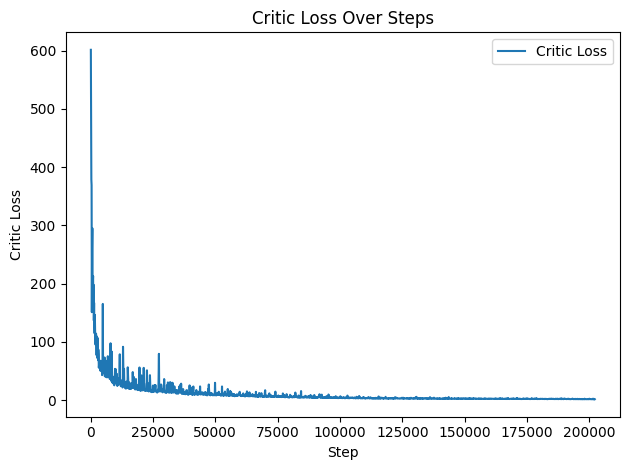

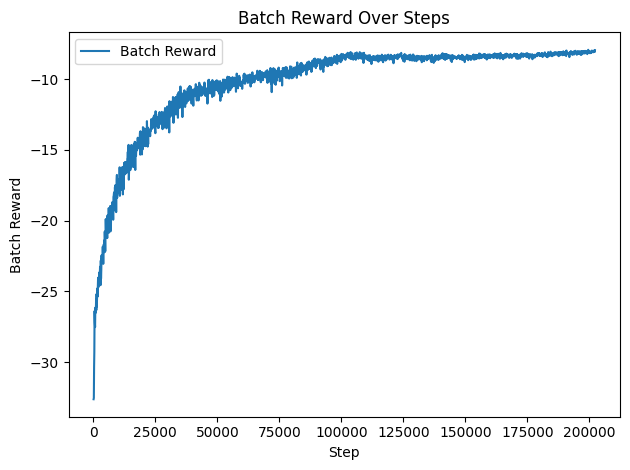

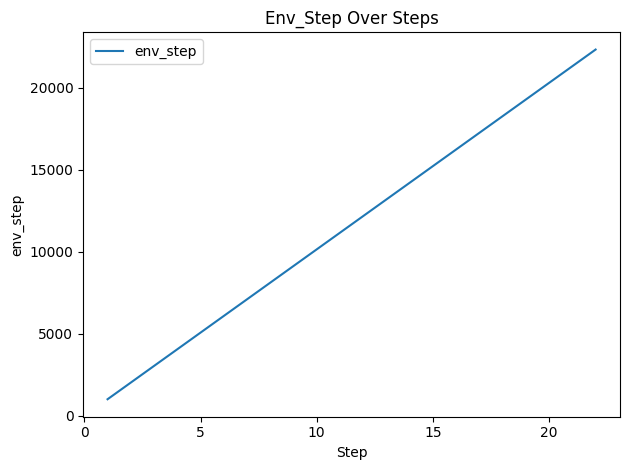

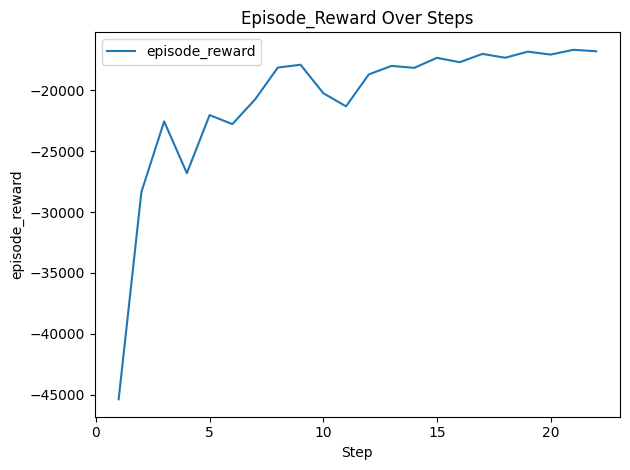

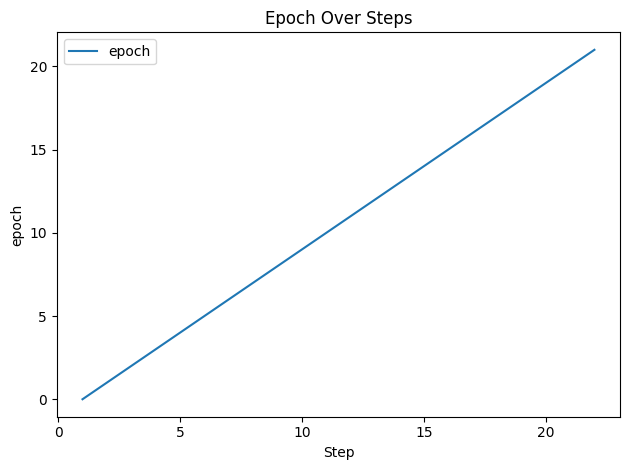

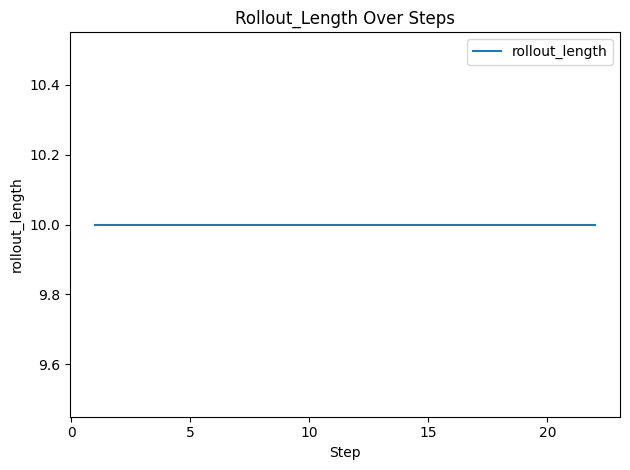

In [ ]:
plt.plot_learning_metrics(os.getcwd()+"/exp/macura")